Related urls, will remove once finished:
- https://www.tensorflow.org/tutorials/structured_data/time_series#multi-step_models

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import itertools

2023-12-09 11:31:19.307051: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-09 11:31:19.399346: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-09 11:31:19.399383: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-09 11:31:19.400308: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-09 11:31:19.413704: I tensorflow/core/platform/cpu_feature_guar

In [2]:
file_path = "../data/parsed_dataset.csv"
date_column = "Date_reported"
target_column = "New_deaths"
df = pd.read_csv(file_path, parse_dates=True)
df = df[[date_column, target_column, "New_cases", "Cumulative_cases"]]
df = df.groupby(date_column).sum().reset_index()
df = df.dropna()
date_time = pd.to_datetime(df.pop(date_column), format="%Y-%m-%d")
df.set_index(date_time, inplace=True)

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
scaled_data.shape

(1420, 3)

In [4]:
# Creating a data structure (it does not work when you have only one feature)
def create_data(
    df, n_future, n_past, train_test_split_percentage, validation_split_percentage
):
    n_feature = df.shape[1]
    x_data, y_data = [], []

    for i in range(n_past, len(df) - n_future + 1):
        x_data.append(df[i - n_past : i, 0:n_feature])
        y_data.append(df[i + n_future - 1 : i + n_future, 0])

    split_training_test_starting_point = int(
        round(train_test_split_percentage * len(x_data))
    )
    split_train_validation_starting_point = int(
        round(split_training_test_starting_point * (1 - validation_split_percentage))
    )

    x_train = x_data[:split_train_validation_starting_point]
    y_train = y_data[:split_train_validation_starting_point]

    # if you want to choose the validation set by yourself, uncomment the below code.
    x_val = x_data[
        split_train_validation_starting_point:split_training_test_starting_point
    ]
    y_val = x_data[
        split_train_validation_starting_point:split_training_test_starting_point
    ]

    x_test = x_data[split_training_test_starting_point:]
    y_test = y_data[split_training_test_starting_point:]

    return (
        np.array(x_train),
        np.array(x_test),
        np.array(x_val),
        np.array(y_train),
        np.array(y_test),
        np.array(y_val),
    )

In [7]:
# Number of days you want to predict into the future
# Number of past days you want to use to predict the future

X_train, X_test, X_val, y_train, y_test, y_val = create_data(
    df.values,
    n_future=1,
    n_past=25,
    train_test_split_percentage=0.8,
    validation_split_percentage=0,
)

In [8]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(1116, 25, 3)
(279, 25, 3)
(1116, 1)
(279, 1)


In [9]:
# ------------------LSTM-----------------------
regressor = Sequential()
regressor.add(
    LSTM(
        units=16,
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2]),
    )
)
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=16, return_sequences=False))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1, activation="linear"))
regressor.compile(
    optimizer="adam", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25, 16)            1280      
                                                                 
 dropout (Dropout)           (None, 25, 16)            0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 3409 (13.32 KB)
Trainable params: 3409 (13.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)
# mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# fit model
history = regressor.fit(
    X_train, y_train, validation_split=0.3, epochs=40, batch_size=64, callbacks=[es]
)

Epoch 1/40
13/13 [==============================] - 6s 127ms/step - loss: 0.0886 - root_mean_squared_error: 0.2977 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0854
Epoch 2/40
13/13 [==============================] - 0s 36ms/step - loss: 0.0521 - root_mean_squared_error: 0.2283 - val_loss: 0.0199 - val_root_mean_squared_error: 0.1411
Epoch 3/40
13/13 [==============================] - 0s 19ms/step - loss: 0.0406 - root_mean_squared_error: 0.2015 - val_loss: 0.0292 - val_root_mean_squared_error: 0.1710
Epoch 4/40
13/13 [==============================] - 0s 27ms/step - loss: 0.0340 - root_mean_squared_error: 0.1843 - val_loss: 0.0196 - val_root_mean_squared_error: 0.1399
Epoch 5/40
13/13 [==============================] - 0s 30ms/step - loss: 0.0290 - root_mean_squared_error: 0.1703 - val_loss: 0.0225 - val_root_mean_squared_error: 0.1499
Epoch 6/40
13/13 [==============================] - 0s 34ms/step - loss: 0.0283 - root_mean_squared_error: 0.1682 - val_loss: 0.0221 - val_root_

In [11]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

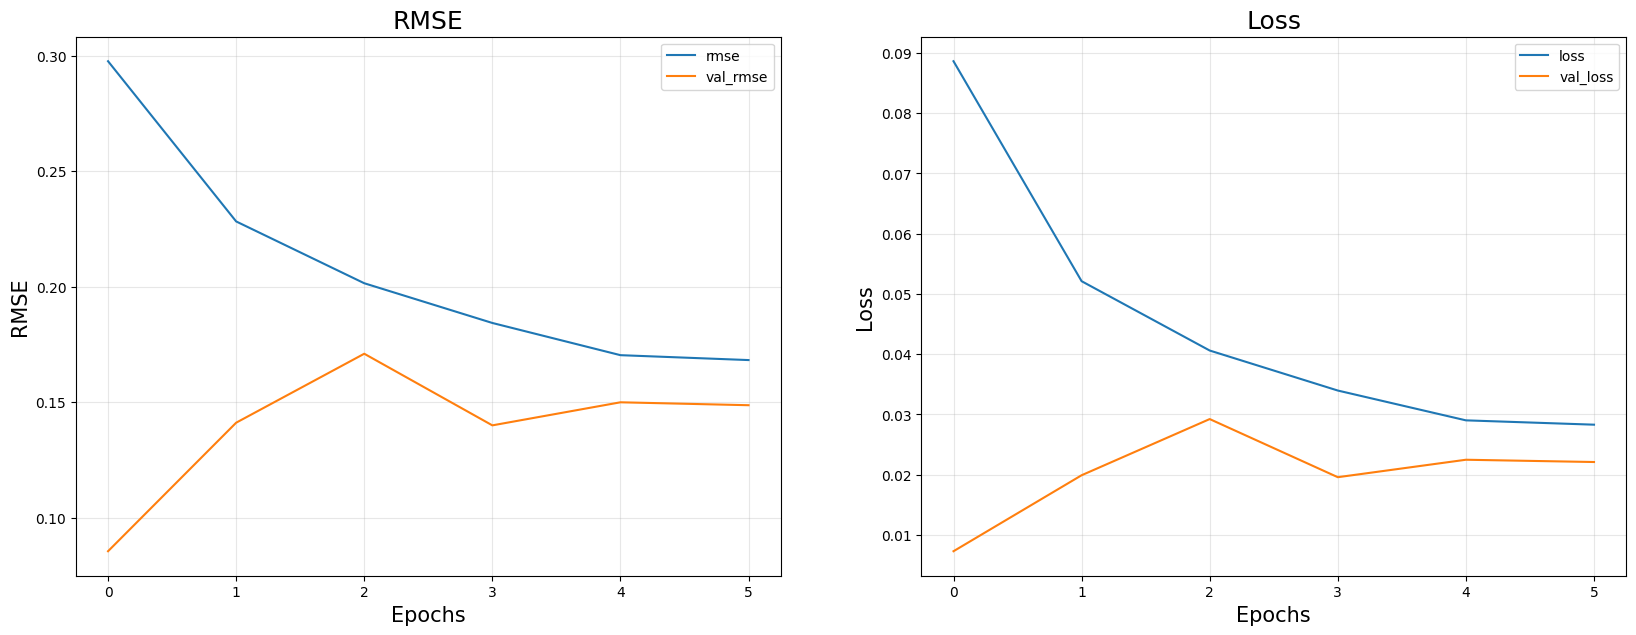

In [12]:
fig = plt.figure(figsize=(20, 7))
fig.add_subplot(121)

# Accuracy
plt.plot(history.epoch, history.history["root_mean_squared_error"], label="rmse")
plt.plot(
    history.epoch, history.history["val_root_mean_squared_error"], label="val_rmse"
)

plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()


# Adding Subplot 1 (For Loss)
fig.add_subplot(122)

plt.plot(history.epoch, history.history["loss"], label="loss")
plt.plot(history.epoch, history.history["val_loss"], label="val_loss")

plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [13]:
results = regressor.evaluate(X_test, y_test)
print("test loss, test acc:", np.round(results, 4))

9/9 [==============================] - 0s 8ms/step - loss: 0.0283 - root_mean_squared_error: 0.1683
test loss, test acc: [0.0283 0.1683]


In [14]:
# detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)


def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):
    (
        first_additional_layer,
        second_additional_layer,
        third_additional_layer,
        n_neurons,
        n_batch_size,
        dropout,
    ) = config
    possible_combinations = list(
        itertools.product(
            first_additional_layer,
            second_additional_layer,
            third_additional_layer,
            n_neurons,
            n_batch_size,
            dropout,
        )
    )

    print(possible_combinations)
    print("\n")

    hist = []

    for i in range(0, len(possible_combinations)):
        print(f"{i+1}th combination: \n")
        print("--------------------------------------------------------------------")

        (
            first_additional_layer,
            second_additional_layer,
            third_additional_layer,
            n_neurons,
            n_batch_size,
            dropout,
        ) = possible_combinations[i]

        # instantiating the model in the strategy scope creates the model on the TPU
        # with tpu_strategy.scope():
        regressor = Sequential()
        regressor.add(
            LSTM(
                units=n_neurons,
                return_sequences=True,
                input_shape=(x_train.shape[1], x_train.shape[2]),
            )
        )
        regressor.add(Dropout(dropout))

        if first_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if second_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if third_additional_layer:
            regressor.add(GRU(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        regressor.add(LSTM(units=n_neurons, return_sequences=False))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=1, activation="linear"))
        regressor.compile(
            optimizer="adam",
            loss="mse",
            metrics=[tf.keras.metrics.RootMeanSquaredError()],
        )

        es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)
        """''
        From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
        alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
        """ ""

        file_path = "best_model.h5"

        mc = ModelCheckpoint(
            file_path, monitor="val_loss", mode="min", verbose=1, save_best_only=True
        )

        """''
        cb = Callback(...)  # First, callbacks must be instantiated.
        cb_list = [cb, ...]  # Then, one or more callbacks that you intend to use must be added to a Python list.
        model.fit(..., callbacks=cb_list)  # Finally, the list of callbacks is provided to the callback argument when fitting the model.
        """ ""

        regressor.fit(
            x_train,
            y_train,
            validation_split=0.3,
            epochs=100,
            batch_size=n_batch_size,
            callbacks=[es, mc],
            verbose=0,
        )

        # load the best model
        # regressor = load_model('best_model.h5')

        train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
        test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

        hist.append(
            list(
                (
                    first_additional_layer,
                    second_additional_layer,
                    third_additional_layer,
                    n_neurons,
                    n_batch_size,
                    dropout,
                    train_accuracy,
                    test_accuracy,
                )
            )
        )

        print(
            f"{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}"
        )

    return hist

In [15]:
config = [
    [True, False],
    [True, False],
    [True, False],
    [16, 32, 64, 128, 256],
    [7, 28, 21, 84, 365],
    [0.2],
]

# list of lists --> [[first_additional_layer], [second_additional_layer], [third_additional_layer], [n_neurons], [n_batch_size], [dropout]]

hist = LSTM_HyperParameter_Tuning(
    config, X_train, y_train, X_test, y_test
)  # change x_train shape

[(True, True, True, 16, 7, 0.2), (True, True, True, 16, 28, 0.2), (True, True, True, 16, 21, 0.2), (True, True, True, 16, 84, 0.2), (True, True, True, 16, 365, 0.2), (True, True, True, 32, 7, 0.2), (True, True, True, 32, 28, 0.2), (True, True, True, 32, 21, 0.2), (True, True, True, 32, 84, 0.2), (True, True, True, 32, 365, 0.2), (True, True, True, 64, 7, 0.2), (True, True, True, 64, 28, 0.2), (True, True, True, 64, 21, 0.2), (True, True, True, 64, 84, 0.2), (True, True, True, 64, 365, 0.2), (True, True, True, 128, 7, 0.2), (True, True, True, 128, 28, 0.2), (True, True, True, 128, 21, 0.2), (True, True, True, 128, 84, 0.2), (True, True, True, 128, 365, 0.2), (True, True, True, 256, 7, 0.2), (True, True, True, 256, 28, 0.2), (True, True, True, 256, 21, 0.2), (True, True, True, 256, 84, 0.2), (True, True, True, 256, 365, 0.2), (True, True, False, 16, 7, 0.2), (True, True, False, 16, 28, 0.2), (True, True, False, 16, 21, 0.2), (True, True, False, 16, 84, 0.2), (True, True, False, 16, 365, 

/home/samuell/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.02399 to 0.02263, saving model to best_model.h5

Epoch 3: val_loss did not improve from 0.02263

Epoch 4: val_loss improved from 0.02263 to 0.01853, saving model to best_model.h5

Epoch 5: val_loss did not improve from 0.01853

Epoch 6: val_loss did not improve from 0.01853

Epoch 7: val_loss did not improve from 0.01853

Epoch 8: val_loss did not improve from 0.01853

Epoch 9: val_loss did not improve from 0.01853
Epoch 9: early stopping
0-th combination = (True, True, True, 16, 7, 0.2) 
 train accuracy: [0.01208226103335619, 0.10991933941841125] and test accuracy: [0.024350488558411598, 0.15604643523693085]
2th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.02273, saving model to best_model.h5

Epoch 2: val_loss improved from 0.02273 to 0.02104, saving model to best_model.h5

Epoch 3: val_loss improved from 0.02104 to 0.02040, saving model to best_model.h5

Epoch 4: val_l

KeyboardInterrupt: 

In [ ]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist

,0,1,2,3,4,5,6,7
45,True,True,False,256,7,0.2,"[0.34128430485725403, 0.5841954350471497]","[0.015950078144669533, 0.1262936145067215]"
119,False,True,True,128,365,0.2,"[0.40547654032707214, 0.6367704272270203]","[0.019572967663407326, 0.13990342617034912]"
113,False,True,True,64,84,0.2,"[0.40884190797805786, 0.6394074559211731]","[0.020047321915626526, 0.14158856868743896]"
68,True,False,True,128,84,0.2,"[0.38435444235801697, 0.6199632883071899]","[0.020282382145524025, 0.14241622388362885]"
125,False,True,False,16,7,0.2,"[0.39981889724731445, 0.6323123574256897]","[0.02034253254532814, 0.14262725412845612]"
...,...,...,...,...,...,...,...,...
4,True,True,True,16,365,0.2,"[0.68843674659729, 0.8297209143638611]","[0.5821943879127502, 0.7630166411399841]"
79,True,False,False,16,365,0.2,"[0.6558093428611755, 0.8098205327987671]","[0.7348453402519226, 0.8572311997413635]"
154,False,False,True,16,365,0.2,"[0.6191141605377197, 0.7868380546569824]","[0.7474299073219299, 0.8645402789115906]"
153,False,False,True,16,84,0.2,"[0.5346857309341431, 0.7312220931053162]","[0.8964783549308777, 0.946825385093689]"


In [ ]:
print(
    f"Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}"
)
print("**************************")
print(f"Results Before Tunning:\n Test Set RMSE: {np.round(results, 4)[1]}\n")
print(f"Results After Tunning:\n Test Set RMSE: {np.round(hist.iloc[0, -1], 4)[1]}\n")
print(
    f"{np.round((results[1] - hist.iloc[0, -1][1])*100/np.round(results, 4)[1])}% Improvement"
)

Best Combination: 
 first_additional_layer = True
 second_additional_layer = True
 third_additional_layer = False
 n_neurons = 256
 n_batch_size = 7
 dropout = 0.2
**************************
Results Before Tunning:
 Test Set RMSE: 0.3931

Results After Tunning:
 Test Set RMSE: 0.1263

68.0% Improvement


In [ ]:
(
    first_additional_layer,
    second_additional_layer,
    third_additional_layer,
    n_neurons,
    n_batch_size,
    dropout,
) = list(hist.iloc[0, :-2])

In [ ]:
regressor = Sequential()
regressor.add(
    LSTM(
        units=n_neurons,
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2]),
    )
)
regressor.add(Dropout(dropout))

if first_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if second_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if third_additional_layer:
    regressor.add(GRU(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

regressor.add(LSTM(units=n_neurons, return_sequences=False))
regressor.add(Dropout(dropout))
regressor.add(Dense(units=1, activation="linear"))
regressor.compile(optimizer="adam", loss="mse")

es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)

file_path = "best_model.h5"

mc = ModelCheckpoint(
    file_path, monitor="val_loss", mode="min", verbose=1, save_best_only=True
)

regressor.fit(
    X_train,
    y_train,
    validation_split=0.3,
    epochs=100,
    batch_size=n_batch_size,
    callbacks=[es, mc],
    verbose=0,
)


Epoch 1: val_loss improved from inf to 0.60355, saving model to best_model.h5


/home/samuell/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.60355 to 0.54122, saving model to best_model.h5

Epoch 3: val_loss improved from 0.54122 to 0.52147, saving model to best_model.h5

Epoch 4: val_loss did not improve from 0.52147

Epoch 5: val_loss did not improve from 0.52147

Epoch 6: val_loss did not improve from 0.52147

Epoch 7: val_loss did not improve from 0.52147

Epoch 8: val_loss did not improve from 0.52147
Epoch 8: early stopping


In [ ]:
regressor.evaluate(X_test, y_test)

9/9 [==============================] - 0s 48ms/step - loss: 0.0703


0.07031791657209396

9/9 [==============================] - 2s 48ms/step


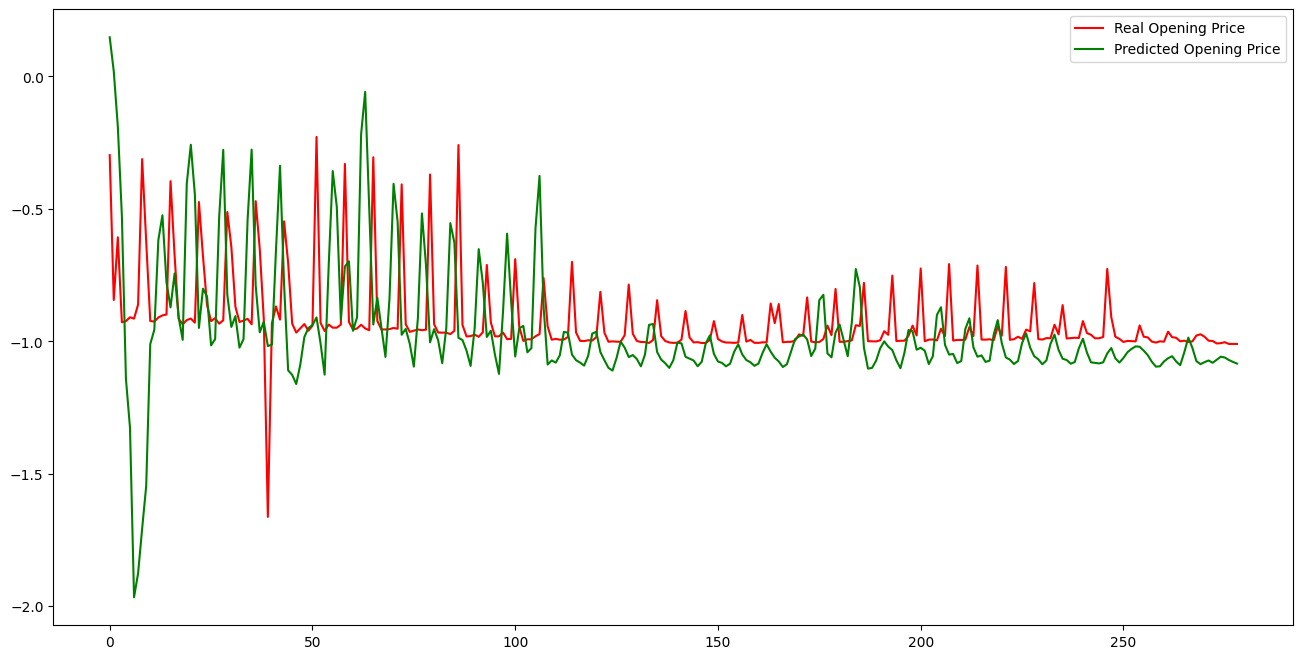

In [ ]:
y_pred = regressor.predict(X_test)

plt.figure(figsize=(16, 8), dpi=100, facecolor="w", edgecolor="k")

plt.plot(y_test, color="red", label="Real Opening Price")
plt.plot(y_pred, color="green", label="Predicted Opening Price")
plt.legend(loc="best")